# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

## 1. Load the data

In [1]:
import pandas as pd
import numpy as np
import math
import json
from pandas.io.json import json_normalize

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
% matplotlib inline

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [5]:
transcript.head(5)

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [6]:
print('The offer portfolio dataset shape is: {}'.format(portfolio.shape))
print('The customer demographic profile dataset shape is: {}'.format(profile.shape))
print('The transaction transcript dataset shape is: {}'.format(transcript.shape))

The offer portfolio dataset shape is: (10, 6)
The customer demographic profile dataset shape is: (17000, 5)
The transaction transcript dataset shape is: (306534, 4)


## 2. Clean the data

### 2.1. Clean portfolio dataset

In [7]:
# Split the channels column into separate columns 
channel = ['web', 'email', 'mobile', 'social']
for c in channel:
    portfolio[c]  = portfolio['channels'].apply(lambda x: 1 if c in x else 0)

In [8]:
# Encode the id combining offer type, difficulty, reward and duration information 
portfolio['offer'] = portfolio.agg('{0[offer_type]}_lev{0[difficulty]}_rew{0[reward]}_day{0[duration]}'.format, axis=1)
portfolio

,channels,difficulty,duration,id,offer_type,reward,web,email,mobile,social,offer
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,0,1,1,1,bogo_lev10_rew10_day7
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1,bogo_lev10_rew10_day5
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,1,0,informational_lev0_rew0_day4
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,1,0,bogo_lev5_rew5_day7
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,1,0,0,discount_lev20_rew5_day10
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3,1,1,1,1,discount_lev7_rew3_day7
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2,1,1,1,1,discount_lev10_rew2_day10
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0,0,1,1,1,informational_lev0_rew0_day3
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5,1,1,1,1,bogo_lev5_rew5_day5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2,1,1,1,0,discount_lev10_rew2_day7


In [9]:
# Drop channels column 
portfolio = portfolio.drop(['channels'], axis=1)

### 2.2. Clean profile dataset 

##### 2.2.1. Handling missing value

In [10]:
# Checking missing value
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [11]:
# For gender, checking the different categorisation
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

In [12]:
# Fill null values for gender with 'N'
profile['gender'] = profile['gender'].fillna('N')

# Split genders columns by in separate column by gender
gender = ['F', 'M','O']
for g in gender:
    profile[g]  = profile['gender'].apply(lambda x: 1 if x==g else 0)

In [13]:
profile.sample(5)

,age,became_member_on,gender,id,income,F,M,O
711,38,20170912,M,c0c8ab46c7714a2da817a69fea4ed043,56000.0,0,1,0
342,73,20180507,F,07ebe89c877e4328b60f4e5676452ee1,79000.0,1,0,0
267,49,20170809,F,7798d98a070845328d838312b65ba846,68000.0,1,0,0
8372,69,20131012,F,94471d354521436e9af9067156a43190,95000.0,1,0,0
3265,56,20170126,F,f89cde99c9bf4182a371dd808a0ad2f1,119000.0,1,0,0


#Drop gender column 
profile = profile.drop(['gender'], axis=1)

In [14]:
# Checking the null profile
null_profile = profile[pd.isnull(profile).any(axis=1)]
null_profile.sample(5)

,age,became_member_on,gender,id,income,F,M,O
729,118,20161025,N,e199fdec031441fb9f1295eb7952be69,NaN,0,0,0
104,118,20170823,N,182e68952b474700b171e21b85c258ac,NaN,0,0,0
15983,118,20170524,N,ad31616fb9094f559cc30051c0512a3b,NaN,0,0,0
1481,118,20180107,N,603f3605295449339d3697415ca7be49,NaN,0,0,0
6611,118,20170529,N,8e7a22dd150f4ecea1a6be17be1d2381,NaN,0,0,0


In [15]:
null_profile.describe()

,age,became_member_on,income,F,M,O
count,2175.0,2.175000e+03,0.0,2175.0,2175.0,2175.0
mean,118.0,2.016804e+07,NaN,0.0,0.0,0.0
std,0.0,1.009105e+04,NaN,0.0,0.0,0.0
min,118.0,2.013080e+07,NaN,0.0,0.0,0.0
25%,118.0,2.016070e+07,NaN,0.0,0.0,0.0
50%,118.0,2.017073e+07,NaN,0.0,0.0,0.0
75%,118.0,2.017123e+07,NaN,0.0,0.0,0.0
max,118.0,2.018073e+07,NaN,0.0,0.0,0.0


**Note:** It seems that for customers with no age, gender, income information, the default age is set at 118. 

In [16]:
# replace age 118 with NaN for consistency with the income column
profile['age'] = profile['age'].replace(118, np.nan)

##### 2.2.2. Checking duplicates

In [17]:
profile['id'].duplicated().sum()

0

##### 2.2.3. Profile dataset summary

In [18]:
profile.describe()

,age,became_member_on,income,F,M,O
count,14825.000000,1.700000e+04,14825.000000,17000.000000,17000.000000,17000.000000
mean,54.393524,2.016703e+07,65404.991568,0.360529,0.499059,0.012471
std,17.383705,1.167750e+04,21598.299410,0.480168,0.500014,0.110977
min,18.000000,2.013073e+07,30000.000000,0.000000,0.000000,0.000000
25%,42.000000,2.016053e+07,49000.000000,0.000000,0.000000,0.000000
50%,55.000000,2.017080e+07,64000.000000,0.000000,0.000000,0.000000
75%,66.000000,2.017123e+07,80000.000000,1.000000,1.000000,0.000000
max,101.000000,2.018073e+07,120000.000000,1.000000,1.000000,1.000000


**Preliminary observations:** 
- The sample age range between the 1st & 3rd quartile is between 42 to 66 
- The minimum income is 30,000
- The gender breakdown is as follow: 36% are female, 50% are male, 1.2% are O 
- For 12.8% of the sample, there is no age, gender and income information (e.g. missing value)

### 2.3. Clean transcript dataset

In [19]:
transcript.sample(5)

,event,person,time,value
156602,offer received,0ce9a07602cc40c298a27089b5f2175a,408,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
41115,offer viewed,4c64918bc4de493a8c995fb47e7ec4c0,96,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
290458,transaction,59f48fff1cda434b94c1349c9ecc4eda,648,{'amount': 2.33}
219837,transaction,8fcb585e133e4905bf90587609d01f49,510,{'amount': 10.02}
202654,offer received,352365e0b86342689793a4be4841d920,504,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}


#### 2.3.1 Parse value columns by offer id, transaction amount, reward amount

In [20]:
# Parse json into dataframe column
value = json_normalize(transcript['value'])
value.head(10)

,amount,offer id,offer_id,reward
0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,NaN,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN
5,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN
6,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN
7,NaN,3f207df678b143eea3cee63160fa8bed,NaN,NaN
8,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
9,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN


In [21]:
# Concat the dataframes
transaction = pd.concat([transcript, value], axis=1)
transaction = transaction.drop(['value'], axis=1)
transaction[transaction['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,amount,offer id,offer_id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,NaN,NaN
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,NaN,NaN
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN,NaN
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,19.67,NaN,NaN,NaN
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,29.72,NaN,NaN,NaN
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,23.93,NaN,NaN,NaN


In [22]:
# Combine "offer id" and "offer_id" columns, then drop offer_id column 
transaction['offer id'] = transaction.apply(lambda x: x['offer_id'] if pd.notna(x['offer_id']) else x['offer id'], axis=1)
transaction = transaction.drop(['offer_id'], axis=1)

In [23]:
# Checking the results
transaction[transaction['person'] == '78afa995795e4d85b5d9ceeca43f5fef']

,event,person,time,amount,offer id,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
15561,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN
47582,transaction,78afa995795e4d85b5d9ceeca43f5fef,132,19.89,NaN,NaN
47583,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0
49502,transaction,78afa995795e4d85b5d9ceeca43f5fef,144,17.78,NaN,NaN
53176,offer received,78afa995795e4d85b5d9ceeca43f5fef,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
85291,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,216,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
87134,transaction,78afa995795e4d85b5d9ceeca43f5fef,222,19.67,NaN,NaN
92104,transaction,78afa995795e4d85b5d9ceeca43f5fef,240,29.72,NaN,NaN
141566,transaction,78afa995795e4d85b5d9ceeca43f5fef,378,23.93,NaN,NaN


#### 2.3.2. Clean transactions that were not influenced by offer

In [24]:
# Sort dataframe by person and time 
transaction = transaction.sort_values(by=['person', 'time'])

# For transaction event, replace unfilled with the preceding offer id   
transaction['offer id'].fillna(method='ffill', inplace=True)

# Sort dataframe by person, offer id and time 
transaction = transaction.sort_values(by=['person', 'offer id','time'])

In [25]:
# Remove transactions that was not preceding by "offer viewed" or another "transaction"
transaction['prev_event_1'] = transaction['event'].shift()
transaction['prev_event_2'] = transaction['prev_event_1'].shift()
transaction['prev_event_3'] = transaction['prev_event_2'].shift()
transaction['prev_event_4'] = transaction['prev_event_3'].shift()

In [26]:
# Transaction validation 
transaction.loc[((transaction['event'] == 'transaction') 
                 & (transaction['prev_event_1'] == 'offer viewed'), 'trans_prev_event')] = 'valid'

In [27]:
# Transaction validation 
transaction.loc[((transaction['event'] == 'transaction') 
                 & (transaction['prev_event_1'] == 'transaction') 
                 & (transaction['prev_event_2'] == 'offer viewed')), 'trans_prev_event'] = 'valid'

In [28]:
# Transaction validation 
transaction.loc[((transaction['event'] == 'transaction') 
                 & (transaction['prev_event_1'] == 'transaction') 
                 & (transaction['prev_event_2'] == 'transaction') 
                 & (transaction['prev_event_3'] == 'offer viewed')), 'trans_prev_event'] = 'valid'

In [29]:
# Transaction validation 
transaction.loc[((transaction['event'] == 'transaction') 
                 & (transaction['prev_event_1'] == 'transaction') 
                 & (transaction['prev_event_2'] == 'transaction') 
                 & (transaction['prev_event_3'] == 'transaction') 
                 & (transaction['prev_event_4'] == 'offer viewed')), 'trans_prev_event'] = 'valid'

In [30]:
# Offer completion validation 
transaction.loc[((transaction['event'] == 'offer completed') 
                 & (transaction['prev_event_1'] == 'offer received')), 'comp_prev_event'] = 'invalid'

In [31]:
# Offer completion validation 
transaction.loc[((transaction['event'] == 'offer completed') 
                 & (transaction['prev_event_1'] == 'offer viewed')), 'comp_prev_event'] = 'invalid'

In [32]:
# Offer completion validation 
transaction['prev_trans_valid'] = transaction['trans_prev_event'].shift()
transaction.loc[((transaction['event'] == 'offer completed') 
                 & (transaction['prev_event_1'] == 'transaction')
                 & (transaction['prev_trans_valid'] != 'valid')), 'comp_prev_event'] = 'invalid'

In [33]:
# Drop invalid transaction
transaction = transaction.drop((transaction[(transaction['event'] == 'transaction') & 
                                             (transaction['trans_prev_event'] != 'valid')]
                                 .index))

In [34]:
# Drop invalid "offer completed" event 
transaction = transaction.drop((transaction[(transaction['event'] == 'offer completed') & 
                                             (transaction['comp_prev_event'] == 'invalid')]
                                 .index))

In [35]:
# Drop unnecessary columns 
transaction = transaction.drop(['prev_event_1','prev_event_2','prev_event_3','prev_event_4',
                           'trans_prev_event','comp_prev_event','prev_trans_valid'], axis=1)

In [36]:
transaction.sort_values(by=['person', 'time']).head(20)

,event,person,time,amount,offer id,reward
55972,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
77705,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,5a8bc65990b245e5a138643cd4eb9837,NaN
89291,transaction,0009655768c64bdeb2e877511632db8f,228,22.16,5a8bc65990b245e5a138643cd4eb9837,NaN
113605,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,3f207df678b143eea3cee63160fa8bed,NaN
139992,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,3f207df678b143eea3cee63160fa8bed,NaN
153401,offer received,0009655768c64bdeb2e877511632db8f,408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
187554,offer viewed,0009655768c64bdeb2e877511632db8f,456,NaN,f19421c1d4aa40978ebb69ca19b0e20d,NaN
204340,offer received,0009655768c64bdeb2e877511632db8f,504,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
233413,offer viewed,0009655768c64bdeb2e877511632db8f,540,NaN,fafdcd668e3743c1bb461111dcafc2a4,NaN
237784,transaction,0009655768c64bdeb2e877511632db8f,552,13.56,fafdcd668e3743c1bb461111dcafc2a4,NaN


### 2.3. Combine the dataset

In [37]:
# Combine transaction and customer profile dataframe
df = pd.merge(transaction, profile, left_on='person', right_on='id', how='left')
df = df.drop(['id'], axis=1)

In [38]:
# Combine offer portfolio dataframe
df = pd.merge(df, portfolio, left_on='offer id', right_on='id', how='left')
df = df.drop(['id', 'offer id'], axis=1)

In [39]:
df.head()

,event,person,time,amount,reward_x,age,became_member_on,gender,income,F,...,O,difficulty,duration,offer_type,reward_y,web,email,mobile,social,offer
0,offer received,0009655768c64bdeb2e877511632db8f,576,NaN,NaN,33.0,20170421,M,72000.0,0,...,0,10,7,discount,2,1,1,1,0,discount_lev10_rew2_day7
1,offer received,0009655768c64bdeb2e877511632db8f,336,NaN,NaN,33.0,20170421,M,72000.0,0,...,0,0,4,informational,0,1,1,1,0,informational_lev0_rew0_day4
2,offer viewed,0009655768c64bdeb2e877511632db8f,372,NaN,NaN,33.0,20170421,M,72000.0,0,...,0,0,4,informational,0,1,1,1,0,informational_lev0_rew0_day4
3,offer received,0009655768c64bdeb2e877511632db8f,168,NaN,NaN,33.0,20170421,M,72000.0,0,...,0,0,3,informational,0,0,1,1,1,informational_lev0_rew0_day3
4,offer viewed,0009655768c64bdeb2e877511632db8f,192,NaN,NaN,33.0,20170421,M,72000.0,0,...,0,0,3,informational,0,0,1,1,1,informational_lev0_rew0_day3


In [40]:
# Rename person and rewards columns  
df = df.rename(columns={'person': 'customer_id','reward_x': 'reward_received', 'reward_y': 'offer_reward'})

In [41]:
# Convert time columns from hours into days to facilitate the comparison with the offer duration
df['time'] = df['time']/24

In [42]:
# Encode 'customer_id' and 'offer id'
df[['customer_id']] = df[['customer_id']].apply(lambda x: pd.factorize(x)[0] + 1)

In [43]:
df.head()

,event,customer_id,time,amount,reward_received,age,became_member_on,gender,income,F,...,O,difficulty,duration,offer_type,offer_reward,web,email,mobile,social,offer
0,offer received,1,24.0,NaN,NaN,33.0,20170421,M,72000.0,0,...,0,10,7,discount,2,1,1,1,0,discount_lev10_rew2_day7
1,offer received,1,14.0,NaN,NaN,33.0,20170421,M,72000.0,0,...,0,0,4,informational,0,1,1,1,0,informational_lev0_rew0_day4
2,offer viewed,1,15.5,NaN,NaN,33.0,20170421,M,72000.0,0,...,0,0,4,informational,0,1,1,1,0,informational_lev0_rew0_day4
3,offer received,1,7.0,NaN,NaN,33.0,20170421,M,72000.0,0,...,0,0,3,informational,0,0,1,1,1,informational_lev0_rew0_day3
4,offer viewed,1,8.0,NaN,NaN,33.0,20170421,M,72000.0,0,...,0,0,3,informational,0,0,1,1,1,informational_lev0_rew0_day3


## 3. Exploratory Data Analysis

### 3.1. Demographic profile

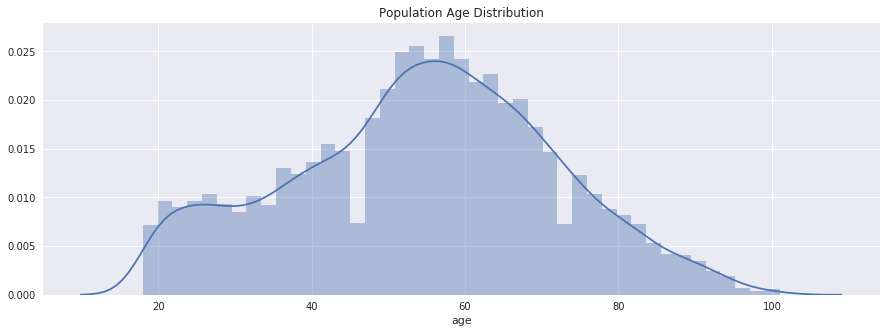

In [44]:
pop_profile = profile.dropna()
plt.figure(figsize=(15,5))
ax = sns.distplot(pop_profile['age'])
ax.set_title('Population Age Distribution')
plt.show()

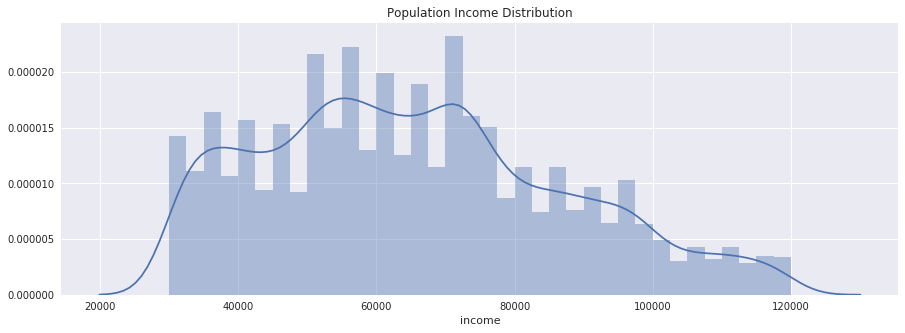

In [45]:
plt.figure(figsize=(15,5))
ax = sns.distplot(pop_profile['income'])
ax.set_title('Population Income Distribution')
plt.show()

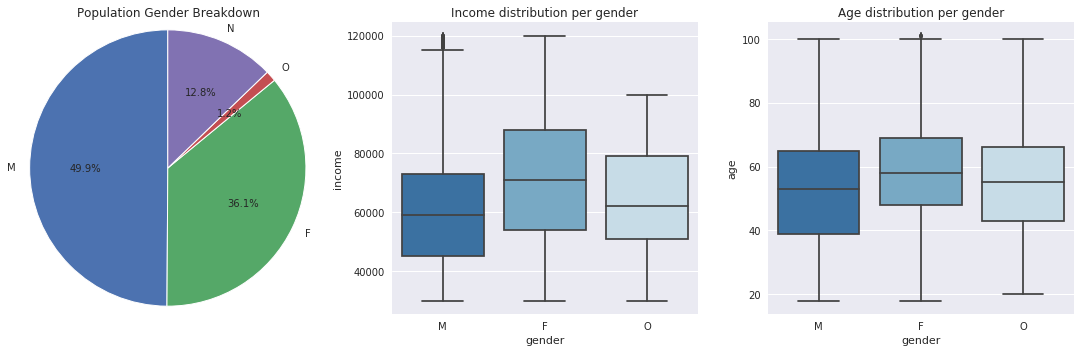

In [46]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(15,5))

# Population Gender Breakdown
gender = profile['gender'].value_counts(normalize=True)[['M', 'F', 'O', 'N']]
sns.set_palette(sns.color_palette("RdBu_r", 7))
ax1.pie(gender, labels=gender.index, autopct='%1.1f%%', startangle=90, wedgeprops={"edgecolor":"white",'linewidth': 1})
ax1.axis('equal')
ax1.set_title('Population Gender Breakdown')

# Income distribution per gender
sns.boxplot('gender', 'income', data=profile, ax=ax2,order=['M', 'F', 'O'])
ax2.set_title('Income distribution per gender')

# Age distribution per gender
sns.boxplot('gender', 'age', data=profile, ax=ax3,order=['M', 'F', 'O'])
ax3.set_title('Age distribution per gender')

plt.tight_layout()
plt.show()

### 3.2. Offer completion rate by offer type

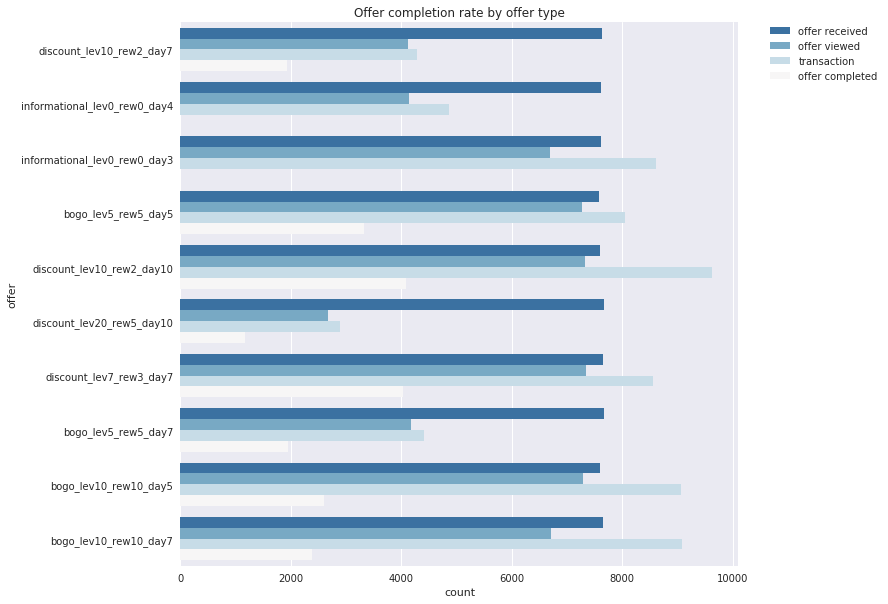

In [50]:
plt.figure(figsize=(10,10))
ax = sns.countplot(y="offer", hue="event", data=df)
ax.set_title('Offer completion rate by offer type')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()